This code had a Overfitting problem

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [45]:
Data = pd.read_csv('fulldata.csv')


In [46]:
Data.info()
Data.describe().transpose()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189488 entries, 0 to 189487
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    189488 non-null  object 
 1   energy  189488 non-null  float64
 2   diag    189488 non-null  float64
 3   pca1    189488 non-null  float64
 4   pca2    189488 non-null  float64
 5   pca3    189488 non-null  float64
dtypes: float64(5), object(1)
memory usage: 8.7+ MB


,count,mean,std,min,25%,50%,75%,max
energy,189488.0,23.224939,24.828596,0.280758,0.578519,35.489707,38.119598,99.991317
diag,189488.0,0.233942,0.251381,0.005000,0.005000,0.378000,0.378000,1.000000
pca1,189488.0,0.126102,0.193949,-0.878344,0.023608,0.057811,0.193317,0.996973
pca2,189488.0,0.053110,0.225161,-0.983825,-0.010437,0.022784,0.175336,0.979041
pca3,189488.0,-0.000552,0.231339,-0.960883,-0.062514,0.008743,0.097253,0.981669


In [47]:
null_counts = Data.isna().sum()
null_counts

name      0
energy    0
diag      0
pca1      0
pca2      0
pca3      0
dtype: int64

<AxesSubplot: >

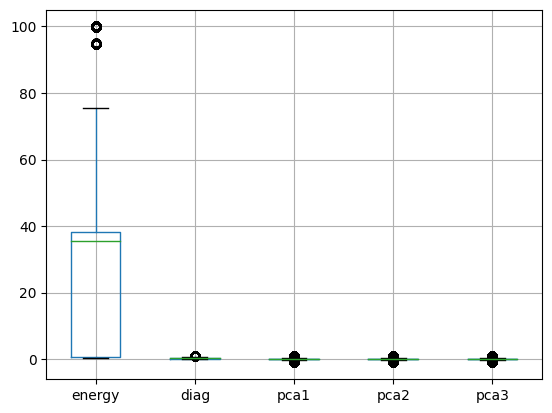

In [48]:
features = ['energy','diag','pca1', 'pca2', 'pca3']
Data.boxplot(features)

In [49]:
selected_features = ['diag','pca1','pca2','pca3']
X = Data[selected_features]

In [50]:
selected_features = ['diag','pca1','pca2','pca3','count','Bin']
Data['count'] = Data.groupby('name')['name'].transform('count')
bins = [0, 13, 20, float("inf")]
labels = ['0-13', '14-20', '20+']
Data['Bin'] = pd.cut(Data['count'], bins=bins, labels=labels)
X = Data[selected_features]
X = pd.get_dummies(X, columns=['Bin'])  # One-hot encode categorical variables


In [51]:
target =  ['energy']
y = Data[target]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


In [53]:
xgb_model = XGBRegressor(objective='reg:squarederror')


In [54]:
param_grid = {
    'n_estimators': [10000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [55]:
random_search = RandomizedSearchCV(
        xgb_model, 
        param_distributions=param_grid, 
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1
)

In [56]:
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [10000],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [57]:

best_params = random_search.best_params_
print("Best parameters found: ", best_params)

best_model = random_search.best_estimator_

Best parameters found:  {'subsample': 0.9, 'n_estimators': 10000, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [58]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ['mae']
best_model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)


C:\Users\gts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [59]:
results = best_model.evals_result()
train_loss = results['validation_0']['mae']
test_loss = results['validation_1']['mae']

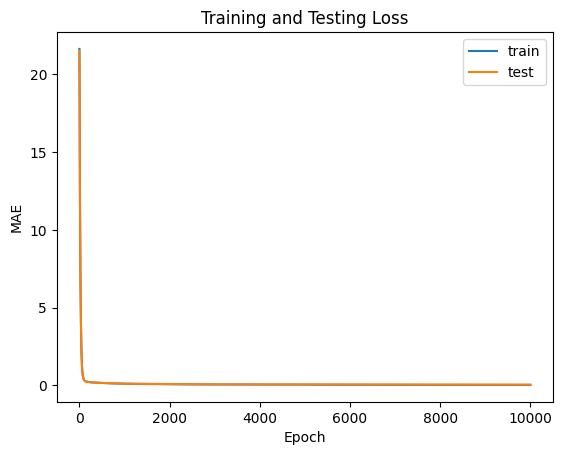

Mean absolute error on training set: 0.031
Mean absolute error on testing set: 0.050

   Predicted Energy  Actual Energy
0         94.868538      94.862968
1          0.614307       0.583955
2         35.549068      35.517664
3         38.157734      38.118823
4         38.089466      37.998993
5         38.178852      38.118540
6          0.580322       0.580465
7          0.571838       0.569907
8         38.121059      38.117709
9          0.595103       0.576352


In [60]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

y_pred_train = best_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f"Mean absolute error on training set: {mae_train:.3f}")

y_pred_test = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"Mean absolute error on testing set: {mae_test:.3f}\n")

predicted_output_train = best_model.predict(X_train)
actual_output_train = y_train.values.flatten()

df_train = pd.DataFrame({'Predicted Energy': predicted_output_train, 'Actual Energy': actual_output_train})
print(df_train.head(10))